# Aplicación del modelo de aprendizaje automático no supervisado K-Means (1-D) para efectos de identificar los clusters y el umbral máximo a partir del cual un operador de telecomunicaciones se considera pequeño para efectos de determinar su elegibilidad en el Comité de Pequeños Operadores.

### Datos

El umbral máximo para determinar si un proveedor de servicios de telecomunicaciones, con fines comerciales, es elegible para participar en el Comité, será calculado a partir de los datos de ingreso nominal acumulados anualmente (al cuarto trimestre del año anterior), los cuales han sido reportados por los operadores y publicados en el Banco de Información de Telecomunicaciones del Instituto Federal de Telecomunicaciones.

Como primer paso, serán acumulados los ingresos anuales publicados en el Banco de Información de Telecomunicaciones, con información al cierre del cuarto trimestre del año inmediato anterior y se realizan algunos ajustes tendientes a consolidar los datos por grupo de interés económico, a fin de comenzar el análisis correspondiente.


### Metodología

El referido umbral se calcula a partir del método de agrupamiento conocido como k-medias o k-means (como se le denomina en el idioma inglés). Se trata de un algoritmo de aprendizaje automático no supervisado que busca identificar los grupos de observaciones (i.e. los ingresos nominales acumulados anualmente) que son similares. Para ello, se parte del concepto básico de “distancia” para determinar similitudes entre los operadores de telecomunicaciones. Por ejemplo, si tomamos los ingresos nominales acumulados anuales de dos empresas, la distancia entre sus respectivos datos es una medida del grado de cercanía o similitud que existe entre las mismas.

Como se ilustra en el siguiente diagrama, se define aleatoriamente un prototipo para cada grupo y se mide la distancia que tienen los ingresos nominales acumulados anualmente de cada elemento respecto al prototipo o centroide (v.gr. punto medio de los objetos). Posteriormente, ese centroide se vuelve a definir para cada grupo y este proceso se repite hasta que los objetos no cambien de grupo y que los centroides no sufran variaciones; lo que confirma que existe evidencia de que los grupos están correctamente definidos.

Para la determinación del número óptimo de clusters o grupos (k), se utiliza el criterio denominado Elbow, que consiste en seleccionar el k donde la reducción de la suma de la distancia cuadrática de los elementos de cada grupo a su centroide (inercia) ya no es significativa. Lo que implica que un cluster adicional ya no aumenta significativamente la similitud entre los elementos de cada grupo, reduciendo la eficiencia en la agrupación sin una ganancia significativa en la convergencia o similitud de cada elemento en cada grupo . En este sentido, el principio de selección óptima de k es el de tener un valor reducido de inercia y el número menor de centroides o agrupaciones.

<img title="a title" alt="Alt text" src="kmeans.png">


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.cluster.vq import vq, kmeans, whiten
import dataframe_image as dfi
import math
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
# Es importante mencionar que esta base de datos proviene de la última actualización en el Banco de Información de Telecomunicaciones
# del IFT, consultado el 19 de agosto de 2022. 
# Por este motivo se incluye en este repositorio esa versión de la base de datos a efectos de que si desea replicar el 
# resultado, lo haga con este conjunto de datos, toda vez que la información en el BIT podría variar sin previo aviso.

ingresos = pd.read_csv('TD_INGRESOS_TELECOM_ITE_VA_octubre.csv', encoding ='Latin1')
ingresos

,FOLIO,ANIO,TRIM,FECHA,CONCESIONARIO,K_EMPRESA,EMPRESA,K_GRUPO,GRUPO,I_FIJO_MOVIL,INGRESOS_TOTAL_E,I_ANUAL_TRIM
0,100025,2021,1,15-mar-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
1,100025,2021,2,15-jun-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
2,100025,2021,3,15-sep-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
3,100025,2021,4,15DEC2021,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
4,100028,2021,1,15-mar-21,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,389669,Trimestral
...,...,...,...,...,...,...,...,...,...,...,...,...
2651,999997,2014,3,15-sep-14,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2652,999997,2014,4,15DEC2014,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2653,999997,2015,1,15-mar-15,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2654,999997,2015,2,15-jun-15,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,720000,Trimestral


In [4]:
ingresos['GRUPO'].unique()

array(['ABILIO VILLARREAL MORGA', 'GRUPO TELEVISA',
       'AGUSTIN PEREZ VIEYRA', 'ALEJANDRO ALFONSO MELGAREJO ALTAMIRANO',
       'ALEJANDRO MELGAREJO CORTES', 'ARELY ISABEL GONGORA PECH',
       'ADA CRISTINA MAGAÑA CASTRO', 'DANIEL GARCIA GODINEZ',
       'FRANCISCO GUERRA GARCIA', 'GABRIEL BUTRON CHIAPA',
       'GENY MARGARITA MOGUEL REJON', 'GUILLERMO MEDELLIN MILAN',
       'GUILLERMO ZARATE GARCIA', 'JAIME SANCHEZ SANCHEZ',
       'JESUS MIGUEL FERNANDEZ GUERRERO', 'JOSE JULIAN SACRAMENTO GARZA',
       'MANUEL LOPEZ AVILA', 'MARCO ANTONIO ROSALES HERRERA',
       'RAFAEL SANCHEZ NAZARIEGA', 'ROBERTO LOPEZ BRAVO',
       'SARA QUIROZ CHAPA', 'IUSACELL-UNEFÓN', 'LOGITEL', 'TV-K',
       'TELEFÓNICA', 'COSMORED', 'TELECAB', 'ULTRAVISION', 'STARGROUP',
       'ALESTRA', 'AXTEL', 'MEGACABLE-MCM', 'TELECABLE DE RIOVERDE',
       'GRUPO TELECABLE', 'GLOBALSAT', 'TELECOM NACIONAL',
       'GRUPO SALINAS', 'AXESAT', 'AIRECABLE', 'CABLECOM', 'USA TELECOM',
       'CODITEL', 'COMCAB', '

In [5]:
len(ingresos['GRUPO'].unique())

199

In [6]:
ingresos.columns

Index(['FOLIO', 'ANIO', 'TRIM', 'FECHA', 'CONCESIONARIO', 'K_EMPRESA',
       'EMPRESA', 'K_GRUPO', 'GRUPO', 'I_FIJO_MOVIL', 'INGRESOS_TOTAL_E',
       'I_ANUAL_TRIM'],
      dtype='object')

In [7]:
# seleccionamos columnas relevantes
variables_relevantes = ['ANIO','TRIM', 'CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']

ingresos2 = ingresos[variables_relevantes]
ingresos2

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2651,2014,3,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2652,2014,4,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2653,2015,1,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2654,2015,2,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,720000


In [8]:
# seleccionar sólo los registro de 2021
ingresos = ingresos2[ingresos2['ANIO']==2021]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2640,2021,1,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2641,2021,2,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2642,2021,3,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2643,2021,4,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,123094


# Corrección de grupos de interés en el conjunto de datos

Con base en la información proporcionada por la Unidad de Competencia Económica respecto a los Grupos de Interés que tienen identificados, se realizaron los siguientes cambios al marco de datos de ingresos que estamos utilizando para el cálculo del umbral de pequeño operador; publicado en el BIT al 19 de agosto de 2022:

- Se incluye en el grupo de interés económico HISPASAT a la empresa AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.
- Se incluye en el grupo de interés económico GRUPO TELEVISA a la empresa GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V. (GTAC).
- Se incluye en el grupo de interés económico TRANSTELCO a la empresa MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.
- Se incluyen en el grupo de interés económico MVS las empresas: MVSTV y DSH.


In [9]:
# Primero HISPASAT
print(ingresos[ingresos['EMPRESA']=='AXESS'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')
ingresos[ingresos['EMPRESA']=='AXESS']

     ANIO  TRIM                             CONCESIONARIO EMPRESA   GRUPO  \
385  2021     2  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
386  2021     3  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
387  2021     4  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   

     INGRESOS_TOTAL_E  
385          60667313  
386          68625291  
387          88628131  


<ipython-input-9-7dc6878566fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
385,2021,2,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,60667313
386,2021,3,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,68625291
387,2021,4,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,88628131


In [10]:
# Segundo Grupo Televisa
print(ingresos[ingresos['CONCESIONARIO']=='GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')
ingresos[ingresos['EMPRESA']=='GTAC REDES DE FIBRA OPTICA']

     ANIO  TRIM                                      CONCESIONARIO  \
581  2021     1  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
582  2021     2  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
583  2021     3  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
584  2021     4  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   

                        EMPRESA                       GRUPO  INGRESOS_TOTAL_E  
581  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         228948471  
582  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         196098888  
583  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         355289838  
584  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         282197600  


<ipython-input-10-98df99182ec1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
581,2021,1,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,228948471
582,2021,2,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,196098888
583,2021,3,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,355289838
584,2021,4,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,282197600


In [11]:
# Tercero Transtelco
print(ingresos[ingresos['CONCESIONARIO']=='MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')
ingresos[ingresos['EMPRESA']=='MAXCOM']

      ANIO  TRIM                              CONCESIONARIO EMPRESA   GRUPO  \
1896  2021     1  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1897  2021     2  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1898  2021     3  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1899  2021     4  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   

      INGRESOS_TOTAL_E  
1896         154326158  
1897         157745550  
1898         154123979  
1899         157402483  


<ipython-input-11-19fa40c9fb05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1896,2021,1,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154326158
1897,2021,2,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157745550
1898,2021,3,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154123979
1899,2021,4,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157402483


In [12]:
ingresos[ingresos['EMPRESA']=='DISH']

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1103,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1373486398
1104,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1298658657
1105,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1264047268
1106,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1211104115


In [13]:
# Quinto DISH-MVS
print(ingresos[ingresos['CONCESIONARIO']=='COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S. DE R.L. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')
ingresos[ingresos['EMPRESA']=='DISH']

      ANIO  TRIM                                      CONCESIONARIO EMPRESA  \
1103  2021     1  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1104  2021     2  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1105  2021     3  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1106  2021     4  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   

         GRUPO  INGRESOS_TOTAL_E  
1103  DISH-MVS        1373486398  
1104  DISH-MVS        1298658657  
1105  DISH-MVS        1264047268  
1106  DISH-MVS        1211104115  


<ipython-input-13-3309da2ae005>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1103,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1373486398
1104,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1298658657
1105,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1264047268
1106,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1211104115


In [14]:
# Sexto DISH-MVS
print(ingresos[ingresos['EMPRESA']=='MVSTV'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')
ingresos[ingresos['EMPRESA']=='MVSTV']

      ANIO  TRIM          CONCESIONARIO EMPRESA GRUPO  INGRESOS_TOTAL_E
1764  2021     1  COMBAND, S.A. DE C.V.   MVSTV   MVS           1854471
1765  2021     2  COMBAND, S.A. DE C.V.   MVSTV   MVS           1355173
1766  2021     3  COMBAND, S.A. DE C.V.   MVSTV   MVS           2842491
1767  2021     4  COMBAND, S.A. DE C.V.   MVSTV   MVS           5357193


<ipython-input-14-b827a2e0f14c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1764,2021,1,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1854471
1765,2021,2,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1355173
1766,2021,3,"COMBAND, S.A. DE C.V.",MVSTV,MVS,2842491
1767,2021,4,"COMBAND, S.A. DE C.V.",MVSTV,MVS,5357193


In [15]:
# Existen huecos en los datos públicos en proveedores importantes como Axtel (4T2021), Cablevisión, Virgin Mobile (4T2021), QBO CEL (2T Y 4T2021), por mencionar algunos.
ingresos[ingresos['INGRESOS_TOTAL_E'].isna()==True]
# no obstante, partimos de que es la información disponible para este ejercicio.

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
570,2021,2,"CABLEMAS TELECOMUNICACIONES, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
790,2021,2,"CABLEVISION RED, S.A. DE C.V.",CABLEVISION RED,GRUPO TELEVISA,NaN
866,2021,2,"TV CABLE DE ORIENTE, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
968,2021,2,"TELEVISION INTERNACIONAL, S.A. DE C.V.",TELEVISION INTERNACIONAL,GRUPO TELEVISA,NaN
1494,2021,2,"CABLEVISION, S.A. DE C.V.",CABLEVISION,GRUPO TELEVISA,NaN
1862,2021,3,"CTL MEXICO LANDING, S. DE R.L.",CENTURYLINK,CENTURYLINK,NaN
1945,2021,1,"ELEKTRA SATELITAL, S.A. DE C.V.",GRUPO ELEKTRA,GRUPO SALINAS,NaN
2029,2021,4,"VIRGIN MOBILE MEXICO, S. DE R.L. DE C.V.",VIRGIN MOBILE,VIRGIN MOBILE,NaN
2110,2021,2,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN
2112,2021,4,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN


In [16]:
ingresos.dtypes

ANIO                float64
TRIM                float64
CONCESIONARIO        object
EMPRESA              object
GRUPO                object
INGRESOS_TOTAL_E    float64
dtype: object

In [17]:
# no consideremos los missing values

ingresos = ingresos[ingresos['INGRESOS_TOTAL_E'].isna()!=True]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2640,2021,1,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2641,2021,2,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2642,2021,3,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2643,2021,4,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,123094


In [18]:
lista_columnas = ['GRUPO', 'INGRESOS_TOTAL_E']
ingresos2 = ingresos[lista_columnas]
ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,ABILIO VILLARREAL MORGA,0
1,ABILIO VILLARREAL MORGA,0
2,ABILIO VILLARREAL MORGA,0
3,ABILIO VILLARREAL MORGA,0
4,GRUPO TELEVISA,389669
...,...,...
2640,CITRO TELECOM,0
2641,CITRO TELECOM,0
2642,CITRO TELECOM,0
2643,CITRO TELECOM,123094


In [19]:
ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])

<ipython-input-19-0e8230c4d54c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])


In [20]:
# ya no tenemos missings

ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,ABILIO VILLARREAL MORGA,0
1,ABILIO VILLARREAL MORGA,0
2,ABILIO VILLARREAL MORGA,0
3,ABILIO VILLARREAL MORGA,0
4,GRUPO TELEVISA,389669
...,...,...
2640,CITRO TELECOM,0
2641,CITRO TELECOM,0
2642,CITRO TELECOM,0
2643,CITRO TELECOM,123094


In [35]:
# Agrupados
ingresos_agrupados = ingresos2.groupby(['GRUPO']).sum()
ingresos_agrupados

,INGRESOS_TOTAL_E
GRUPO,
ABILIO VILLARREAL MORGA,0
ADA CRISTINA MAGAÑA CASTRO,0
ADDINTELI,5534961
AGUSTIN PEREZ VIEYRA,2726562
AIRECABLE,13327321
...,...
VERIZON SERVICIOS EMPRESARIALES MEXICO,195055919
VIRGIN MOBILE,146563495
WEEX,33446465


In [22]:
ingresos_agrupados = ingresos_agrupados.reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos_agrupados

,GRUPO,INGRESOS_TOTAL_E
9,AMÉRICA MÓVIL,338320139531
56,GRUPO TELEVISA,59302114566
12,AT&T,55793781168
84,MEGACABLE-MCM,25905272620
139,TELEFÓNICA,24871583943
...,...,...
1,ADA CRISTINA MAGAÑA CASTRO,0
73,JOAQUIN LEON ASPANO,0
26,CABLEXTREMO,0
0,ABILIO VILLARREAL MORGA,0


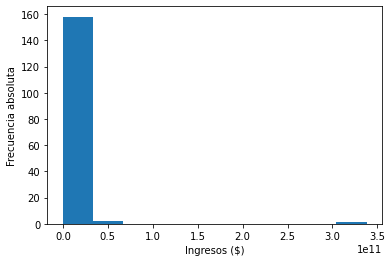

NormaltestResult(statistic=335.13785498596025, pvalue=1.6816648680372634e-73)


In [23]:
plt.hist(ingresos_agrupados['INGRESOS_TOTAL_E'])
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ingresos_agrupados['INGRESOS_TOTAL_E'])) # no pasa la prueba de normalidad (sesgo)

In [24]:
# cuántos ceros tenemos en las cifras
m = ingresos_agrupados[ingresos_agrupados['INGRESOS_TOTAL_E']!=0]

ingresos_agrupados_transformables = m

ingresos_agrupados_transformables

,GRUPO,INGRESOS_TOTAL_E
9,AMÉRICA MÓVIL,338320139531
56,GRUPO TELEVISA,59302114566
12,AT&T,55793781168
84,MEGACABLE-MCM,25905272620
139,TELEFÓNICA,24871583943
...,...,...
13,AXIA CABLECENTRO,43500
31,COMNET,43293
103,REX MOVIL,11422
64,HUGO ABEL PUENTE ANGUIANO,2845


D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


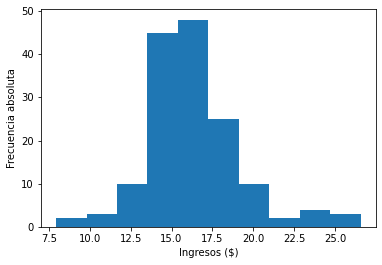

NormaltestResult(statistic=nan, pvalue=nan)


In [25]:
# Aplicar logarítmos para reducir el efecto de la magnitud de los datos.
ln_ingresos = np.log(ingresos_agrupados_transformables['INGRESOS_TOTAL_E']) 

plt.hist(ln_ingresos)
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ln_ingresos))

In [26]:
# Análisis de varianza
var_numpy = np.var(ln_ingresos, ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy}")
print(f'Lo que implica $ {np.exp(var_numpy)}')

sd_numpy = np.std(ln_ingresos,ddof = 0)
print(f"La desviación estándar del ln de los ingresos totales en 2021 es de {sd_numpy}")
print(f'Lo que implica $ {np.exp(sd_numpy)}')

La varianza del ln de los ingresos totales en 2021 es de 8.179125739076019
Lo que implica $ 3565.735914147494
La desviación estándar del ln de los ingresos totales en 2021 es de 2.8599170860491774
Lo que implica $ 17.460079192414206


In [27]:
var_numpy2 = np.var(ingresos_agrupados['INGRESOS_TOTAL_E'], ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy2}")

sd_numpy2 = np.std(ingresos_agrupados['INGRESOS_TOTAL_E'],ddof = 0)
print(f"La desviación estándar de los ingresos totales en 2021 es de {sd_numpy2}")


La varianza del ln de los ingresos totales en 2021 es de 7.527207082259562e+20
La desviación estándar de los ingresos totales en 2021 es de 27435756017.02924


In [28]:
# La media
media = np.mean(ln_ingresos)
print(f"La media del ln de los ingresos 2021 es de {media}")
print(f'Lo que implica una media de $ {np.exp(media)}')

La media del ln de los ingresos 2021 es de 16.415708417309798
Lo que implica una media de $ 13466402.224956347


In [29]:
# Calculando la regla de 68-95-99.7 usando la desviación estándar:
print(f"Casi el 68% de los datos está entre {round(media-sd_numpy,3)} y {round(media+sd_numpy,3)}")
print(f'Lo que implica que el 68% de los operadores tienen ingresos entre {round(np.exp(media-sd_numpy),2)} y {round(np.exp(media+sd_numpy),2)}')
print(f"Casi el 95% de los datos está entre {round(media-2*sd_numpy,3)} y {round(media +2*sd_numpy,3)}")
print(f'Lo que implica que el 95% de los operadores tienen ingresos entre {round(np.exp(media-2*sd_numpy),2)} y {round(np.exp(media +2*sd_numpy),2)}')
print(f"Casi el 99.7% de los datos está entre {round(media-3*sd_numpy,3)} y {round(media+3*sd_numpy,3)}")
print(f'Lo que implica que el 99.7% de los operadores tienen ingresos entre {round(np.exp(media-3*sd_numpy),2)} y {round(np.exp(media +3*sd_numpy),2)}')


Casi el 68% de los datos está entre 13.556 y 19.276
Lo que implica que el 68% de los operadores tienen ingresos entre 771268.11 y 235124449.28
Casi el 95% de los datos está entre 10.696 y 22.136
Lo que implica que el 95% de los operadores tienen ingresos entre 44173.23 y 4105291504.58
Casi el 99.7% de los datos está entre 7.836 y 24.995
Lo que implica que el 99.7% de los operadores tienen ingresos entre 2529.96 y 71678714777.96


In [40]:
ln_ingresos = ln_ingresos.dropna()

In [41]:
# El score z nos dice el número de desviaciones estándar en el que un dato de ingreso está cerca de la media
z_scipy = sts.zscore(ln_ingresos)
print(f"Los score z es {z_scipy}")

Los score z es [ 3.54260271  2.93372225  2.91239906  2.64413398  2.6298956   2.61025832
  2.36007846  2.07986559  1.87049513  1.54399128  1.38022226  1.3650697
  1.34105578  1.27268217  1.26624302  1.20152593  1.11794751  1.06096114
  0.94320711  0.9346734   0.88866307  0.88274853  0.87971129  0.84756568
  0.83744995  0.8347308   0.76964127  0.74787384  0.74206001  0.6941938
  0.64781658  0.63883156  0.63771695  0.6348628   0.51006261  0.50378899
  0.49080971  0.44871266  0.40953639  0.4085217   0.39179323  0.39088197
  0.37867641  0.31810301  0.29150278  0.28792771  0.26413756  0.24918483
  0.23963314  0.2264304   0.18643615  0.18537952  0.17816988  0.17756678
  0.15939688  0.15500318  0.14822376  0.13932257  0.13186631  0.12685835
  0.07367541  0.07366531  0.02659925  0.02160354  0.01252504 -0.00363007
 -0.00592594 -0.0074593  -0.01423165 -0.01439182 -0.02799302 -0.03038523
 -0.050165   -0.06757071 -0.07186513 -0.08284632 -0.12778314 -0.16420606
 -0.17297568 -0.18233423 -0.19277869 -

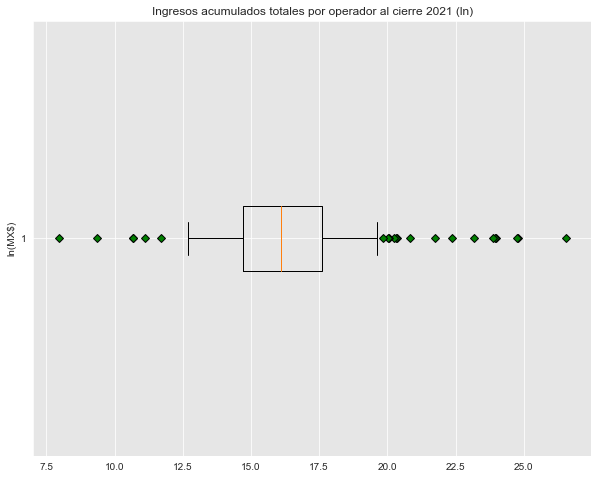

In [42]:
# Prueba de outliers (los grandes operadores)
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Ingresos acumulados totales por operador al cierre 2021 (ln)')
ax1.set_ylabel('ln(MX$)')
ax1.boxplot(ln_ingresos, flierprops=green_diamond, whis=0.75, vert=False)
plt.savefig('criterio_2021.png')
plt.show()

In [43]:
ln_ingresos

9     27
56    25
12    25
84    24
139   24
      ..
40    11
13    11
31    11
103    9
64     8
Name: INGRESOS_TOTAL_E, Length: 152, dtype: float64

In [44]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df = ln_ingresos

# Usual boxplot
ax = sns.boxplot(data=df, orient="h")
 
# Add jitter with the swarmplot function
ax = sns.swarmplot(color="blue", data=df, orient="h")
plt.show()

KeyError: 0

In [45]:
ln_ingresos2 = pd.DataFrame(ln_ingresos)
ln_ingresos3 = ln_ingresos2['INGRESOS_TOTAL_E'].values.astype("float")
ln_ingresos3


array([26.54725844, 24.8059108 , 24.74492825, 23.97771236, 23.93699178,
       23.88083078, 23.16533712, 22.36395156, 21.76516941, 20.83139546,
       20.36302965, 20.31969459, 20.25101676, 20.05547391, 20.03705847,
       19.85197294, 19.61294559, 19.44996932, 19.11320254, 19.08879684,
       18.95721111, 18.94029603, 18.93160975, 18.839676  , 18.81074584,
       18.80296931, 18.61681864, 18.55456558, 18.53793852, 18.40104514,
       18.26841012, 18.24271372, 18.23952603, 18.23136339, 17.87444519,
       17.85650317, 17.81938348, 17.69898941, 17.58694855, 17.5840466 ,
       17.53620457, 17.53359844, 17.49869154, 17.32545666, 17.24938221,
       17.23915779, 17.17111995, 17.12835637, 17.10103933, 17.06328059,
       16.94890035, 16.94587848, 16.92525951, 16.9235347 , 16.87157028,
       16.85900466, 16.83961608, 16.81415941, 16.79283513, 16.77851278,
       16.62641399, 16.62638509, 16.49178006, 16.47749274, 16.45152899,
       16.40532671, 16.39876071, 16.39437544, 16.37500708, 16.37

In [46]:
ln_ingresos2.index

Int64Index([  9,  56,  12,  84, 139,  54,  14,  87,   8, 120,
            ...
             92,  53, 144,  16,  29,  40,  13,  31, 103,  64],
           dtype='int64', length=152)

# Buscando el número de centroides (valores medios) óptimos a partir de la metodología Elbow y minimizar las distorciones.

In [47]:
ln_ingresos3.shape

(152,)

In [48]:
# Cuantificando las distorsiones.

from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ln_ingresos3.reshape(-1, 1))
    distortions.append(kmeanModel.inertia_)

D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


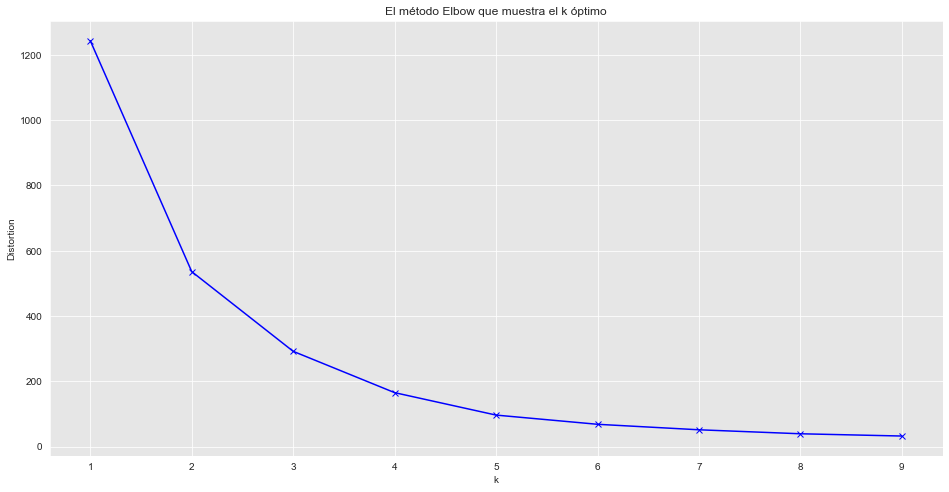

In [49]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('El método Elbow que muestra el k óptimo')
plt.show()

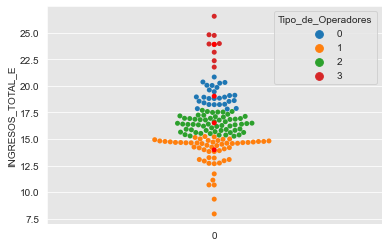

In [51]:
# Busquemos los clusters estadísticamente significativos
#use the kmeans function from scipy
from numpy import random
random.seed((1000,2000))
centroids, avg_distance = kmeans(ln_ingresos3, 4, iter=1000)
#extract the groups from the data
groups, cdit = vq(ln_ingresos3, centroids)
#plot the results
#assign groups back to the dataframe
ln_ingresos2["Tipo_de_Operadores"] = groups
#plot the scatter plot
# Usual boxplot

ax = sns.swarmplot(data=ln_ingresos2, x=np.ones(len(ln_ingresos2)), 
              y='INGRESOS_TOTAL_E', 
              hue=ln_ingresos2['Tipo_de_Operadores'])

ax = sns.swarmplot(data=centroids, color="red")
#ax = sns.boxplot(data=ln_ingresos2["INGRESOS_TOTAL_E"])

# remove legend if necessary
# plt.legend().remove()
plt.savefig('clusters_ingresos.png')
plt.show()

In [ ]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==3].reset_index()
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==0].reset_index()
mediano

pequeño1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==2].reset_index()
pequeño1

pequeño2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==3].reset_index()
pequeño2

pequeño3= ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==1].reset_index()
pequeño3

In [ ]:
# Se reemplazan las variables categóricas por la etiqueta correspondiente
ln_ingresos2["Tipo_de_Operadores"].replace({0: "Mediano", 4: "Grande", 3:"Pequeño2", 2:"Pequeño1", 1:"Pequeño3"}, inplace=True)
ln_ingresos2 = ln_ingresos2.reset_index()
ln_ingresos2

In [ ]:
ingresos_por_grupo = ingresos_agrupados.reset_index()
cluster_total = ingresos_por_grupo.merge(ln_ingresos2, how='left', on='index')
cluster_total.to_csv("Clusters_totales_5clust.csv", encoding="Latin1")

In [ ]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Grande"]
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Mediano"]
mediano

pequeño_1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño1"]
pequeño_1

pequeño_2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño2"]
pequeño_2

pequeño_3 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño3"]
pequeño_3


In [ ]:
ln_ingresos2

In [ ]:
ax = sns.swarmplot(data=ln_ingresos2, x="INGRESOS_TOTAL_E", y="Tipo_de_Operadores", alpha=0.8, linewidth=.9)
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")
plt.savefig("clusters_distribución.jpg")
#plt.show()

In [ ]:
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")

In [ ]:
dir(ax)

In [ ]:
print(ax.findobj())

In [ ]:
np.exp(17.7200000000003)

In [ ]:
avg_distance

# ¿Quiénes son los operadores en cada cluster?

In [ ]:
# Primero preparemos la lista de operadores
ingresos = ingresos[['CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']]
ingresos['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos['INGRESOS_TOTAL_E'])
ingresos = ingresos.groupby(['CONCESIONARIO', 'EMPRESA', 'GRUPO']).sum().reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos

## Grandes

In [ ]:
lista_grandes = grande["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
grandes_operadores = lista_original[lista_original['index'].isin(lista_grandes)]
grandes_operadores.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

In [ ]:
# Las empresas que no serían elegibles por estar en el cluster de los grandes operadores:

lista_cluster_grande = grandes_operadores['GRUPO'].unique()
lista_cluster_grande

In [ ]:
# Se trata de 24 operadores que son por sí solos grandes operadores o pertenecen a un GIE grande. 

lista_empresas_cluster_grande = ingresos[ingresos['GRUPO'].isin(lista_cluster_grande)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_grande.to_csv("Empresas_grandes.csv", encoding="Latin1")

lista_empresas_cluster_grande

## Medianos

In [ ]:
lista_medianos = mediano["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
operadores_medianos = lista_original[lista_original['index'].isin(lista_medianos)]
operadores_medianos.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

In [ ]:
# Las empresas que no serían elegibles por estar en el cluster de los medianos operadores:

lista_cluster_mediano = operadores_medianos['GRUPO'].unique()
lista_cluster_mediano

In [ ]:
# Se trata de 27 operadores que son por sí solos son medianos operadores o pertenecen a un GIE mediano. 

lista_empresas_cluster_medianos = ingresos[ingresos['GRUPO'].isin(lista_cluster_mediano)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_medianos.to_csv("Empresas_medianas.csv", encoding="Latin1")

lista_empresas_cluster_medianos

## Cluster_1 de operadores pequeños

In [ ]:
lista_pequeños1 = pequeño_1["index"]
operadores_pequeños_1 = lista_original[lista_original['index'].isin(lista_pequeños1)]
operadores_pequeños_1.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

In [ ]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_1 = operadores_pequeños_1['GRUPO'].unique()
lista_cluster_pequeños_1

In [ ]:
# Se trata de 42 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_1 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_1)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_1.to_csv("Empresas_pequeñas_c1.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_1

# Cluster 2 de operadores pequeños

In [ ]:
lista_pequeños2 = pequeño_2["index"]
operadores_pequeños_2 = lista_original[lista_original['index'].isin(lista_pequeños2)]
operadores_pequeños_2.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

In [ ]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_2 = operadores_pequeños_2['GRUPO'].unique()
lista_cluster_pequeños_2

In [ ]:
# Se trata de 43 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_2 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_2)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_2.to_csv("Empresas_pequeñas_c2.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_2

In [ ]:
total_ingresos = ingresos_agrupados_transformables["INGRESOS_TOTAL_E"].sum()
ingreos_grandes= lista_empresas_cluster_grande["INGRESOS_TOTAL_E"].sum()
ingresos_medianas = lista_empresas_cluster_medianos["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas1 = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas2 = lista_empresas_cluster_pequeños_2["INGRESOS_TOTAL_E"].sum()

print(f"El 17.6% del total de empresas(cluster empresas grandes) generan el {round(ingreos_grandes/total_ingresos*100,2)}% de los ingresos")
print(f"El 19.9% del total de empresas (cluster empresas medianas) generan el {round(ingresos_medianas/total_ingresos*100,2)}% de los ingresos")
print(f"El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el {round((ingresos_pequeñas1+ingresos_pequeñas2)/total_ingresos*100,2)}% de los ingresos")



In [ ]:
# Análisis con quartiles y rango intercuantil para efectos de identificar los outliers

quartiles = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"El cuartil más bajo de los ingresos es: {lowerq}")
print(f"El cuartil más alto de los ingresos es: {upperq}")
print(f"El rango intercuantil de los ingresos es: {iqr}")
print(f"El ingreso medio es: {quartiles[0.5]} ")


lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr) # se circunscribe al 95.44% de los datos.
print(f"Umbral final donde los valores por encima de {upper_bound} no son elegibles.")



# Conclusiones

### <font color="green"> El umbral para ser elegible como pequeño operador implica ingresos nominales acumulados al cierre de 2021 menores o iguales a <font color="red"> MX$58,743,817 </font>, para efectos de garantizar que la empresa en cuestión se encuentra dentro de alguno de los dos clusters identificados por su ingreso relativamente pequeño.

- Con base en los datos del BIT se registran 85 empresas con ingresos menores o iguales al umbral definido. Esto equivale al 62.5% de todas las empresas.

- El 17.6% del total de empresas (cluster empresas grandes) generan el 98.49% de los ingresos.

- El 19.9% del total de empresas (cluster empresas medianas) generan el 1.32% de los ingresos.

- El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el 0.19% de los ingresos.

- La definición de este umbral con base en una técnica confiable y robusta permite contar con un criterio cuantitativo y objetivo sobre lo que se debe considerar como un operador elegible para participar en el Comité de Pequeños Operadores.

-  Se trata de un criterio claro, transparente y replicable, que brinda certeza jurídica y confianza al sector.

</font>

